In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
from ultralytics import YOLO

In [2]:
df = pd.read_csv('../data/interim/annots_imgs_merged.csv')
bar = df[df['chart-type'] == 'vertical_bar']
bar = bar[['chart-type','data-series','visual-elements.bars','file_name', 'image_path']]
bar = bar.reset_index(drop=True)
bar.columns = ['type','data_series','data','name','path']
bar.head()

,type,data_series,data,name,path
0,vertical_bar,"[{'x': 'Jordan', 'y': 88.35159235668789}, {'x'...","[{'height': 103, 'width': 19, 'x0': 77, 'y0': ...",75c0449f6917,../data/interim/Barplots/75c0449f6917.jpg
1,vertical_bar,"[{'x': 'Cuba', 'y': 75695.38632268383}, {'x': ...","[{'height': 124, 'width': 12, 'x0': 104, 'y0':...",58595c30beab,../data/interim/Barplots/58595c30beab.jpg
2,vertical_bar,"[{'x': 'Jamaica', 'y': 36.43411033235605}, {'x...","[{'height': 75, 'width': 21, 'x0': 62, 'y0': 9...",5022600d52d7,../data/interim/Barplots/5022600d52d7.jpg
3,vertical_bar,"[{'x': '1', 'y': 62.45402663284719}, {'x': '2'...","[{'height': 187, 'width': 11, 'x0': 60, 'y0': ...",32176a89b822,../data/interim/Barplots/32176a89b822.jpg
4,vertical_bar,"[{'x': 'Harney', 'y': 75.91000641635438}, {'x'...","[{'height': 167, 'width': 14, 'x0': 71, 'y0': ...",3d895e511690,../data/interim/Barplots/3d895e511690.jpg


# Loading the Model and Testing the Model:

In [4]:
model = YOLO('../data/YOLO/Barplots/runs/detect/train2/weights/best.pt') 

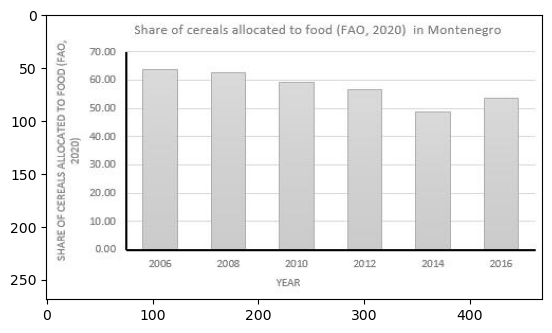

In [129]:
# Test image
path = bar['path'].values[18667]
img = cv2.imread(path)
plt.imshow(img)
plt.show()

In [130]:
# Predict on the image
results = model([path])


0: 384x640 8 bars, 266.3ms
Speed: 5.3ms preprocess, 266.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


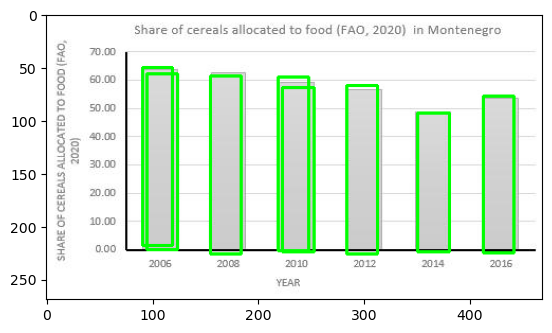

In [131]:
# Extract bboxes from model prediction
bbox_pred = []
res = results[0].boxes.data
for bbox in res:
    x1, y1, x2, y2, probs, pred = bbox
    bbox_pred.append((int(x1.item()), int(y1.item()), int(x2.item()), int(y2.item())))


copy = img.copy()
for bbox in bbox_pred:
    x1, y1, x2, y2 = bbox
    cv2.rectangle(copy, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.imshow(copy)
plt.show()

In [135]:
# Extract actual bboxes from data
data = bar['data'].values[18667]
data = data.replace("'","\"")
data_list = json.loads(data)
bbox_actual = []
for row in data_list:
    x1 = row['x0']
    y1 = row['y0']
    x2 = x1 + row['width']
    y2 = y1 + row['height']
    bbox_actual.append((x1,y1,x2,y2))

bbox_pred = sorted(bbox_pred)

actual_df = pd.DataFrame(bbox_actual, columns=['x1','y1','x2','y2'])
pred_df = pd.DataFrame(bbox_pred, columns=['x1_pred','y1_pred','x2_pred','y2_pred'])

mean_diff_x1 = abs(pred_df['x1_pred']-actual_df['x1']).mean()
mean_diff_y1 = abs(pred_df['y1_pred']-actual_df['y1']).mean()
mean_diff_x2 = abs(pred_df['x2_pred']-actual_df['x2']).mean()
mean_diff_y2 = abs(pred_df['y2_pred']-actual_df['y2']).mean()

In [136]:
pred_df

,x1_pred,y1_pred,x2_pred,y2_pred
0,91,50,119,218
1,95,56,124,222
2,155,58,184,226
3,219,59,248,223
4,223,69,253,224
5,284,67,313,226
6,351,93,381,224
7,413,77,442,225


In [137]:
actual_df

,x1,y1,x2,y2
0,91,52,124,223
1,155,55,188,223
2,220,64,253,223
3,284,71,317,223
4,348,92,381,223
5,413,79,446,223


# Testing on the Rest of the barplots:

In [140]:
test_df = bar[501:].reset_index(drop=True)

In [141]:
x1_diffs = []
y1_diffs = []
x2_diffs = []
y2_diffs = []

from tqdm import tqdm

for i in tqdm(range(len(test_df))):
    #Get bbox predictions
    path = test_df['path'].values[i]
    results = model([path], verbose=False)
    res = results[0].boxes.data
    bbox_pred = []
    for bbox in res:
        x1, y1, x2, y2, probs, pred = bbox
        bbox_pred.append((int(x1.item()), int(y1.item()), int(x2.item()), int(y2.item())))
    bbox_pred = sorted(bbox_pred)

    #Get bbox actuals
    data = test_df['data'].values[i]
    data = data.replace("'","\"")
    data_list = json.loads(data)
    bbox_actual = []
    for row in data_list:
        x1 = row['x0']
        y1 = row['y0']
        x2 = x1 + row['width']
        y2 = y1 + row['height']
        bbox_actual.append((x1,y1,x2,y2))


    actual_df = pd.DataFrame(bbox_actual, columns=['x1','y1','x2','y2'])
    pred_df = pd.DataFrame(bbox_pred, columns=['x1_pred','y1_pred','x2_pred','y2_pred'])

    mean_diff_x1 = abs(pred_df['x1_pred']-actual_df['x1']).mean()
    mean_diff_y1 = abs(pred_df['y1_pred']-actual_df['y1']).mean()
    mean_diff_x2 = abs(pred_df['x2_pred']-actual_df['x2']).mean()
    mean_diff_y2 = abs(pred_df['y2_pred']-actual_df['y2']).mean()
    
    x1_diffs.append(mean_diff_x1)
    y1_diffs.append(mean_diff_y1)
    x2_diffs.append(mean_diff_x2)
    y2_diffs.append(mean_diff_y2)

    


  0%|          | 0/18688 [00:00<?, ?it/s]

100%|██████████| 18688/18688 [1:01:09<00:00,  5.09it/s]


In [142]:
diffs = pd.DataFrame({'x1_diffs':x1_diffs,
                      'y1_diffs':y1_diffs,
                      'x2_diffs':x2_diffs,
                      'y2_diffs':y2_diffs,})

diffs

,x1_diffs,y1_diffs,x2_diffs,y2_diffs
0,0.500000,0.800000,0.400000,0.100000
1,0.466667,1.066667,0.533333,0.466667
2,0.700000,0.800000,1.000000,1.500000
3,0.600000,0.800000,0.600000,0.600000
4,83.900000,19.600000,88.400000,0.500000
...,...,...,...,...
18683,0.500000,0.300000,0.500000,0.100000
18684,1.200000,0.800000,0.800000,0.866667
18685,0.846154,2.615385,0.846154,1.923077
18686,1.083333,0.916667,0.583333,0.166667


# Percentage of Very Accurate Predictions:

In [149]:
round(len(diffs.query('y1_diffs < 2'))/len(diffs),3)*100

75.3

# Percentage of Accurate Predictions:

In [150]:
round(len(diffs.query('y1_diffs > 2 and y1_diffs < 10'))/len(diffs),3)*100

6.7

# Percentage of Poor Predictions:

In [151]:
round(len(diffs.query('y1_diffs > 10'))/len(diffs),3)*100

17.0

# Analyzing bad Predictions:

In [152]:
diffs.query('y1_diffs > 2 and y1_diffs < 10')

,x1_diffs,y1_diffs,x2_diffs,y2_diffs
29,5.826087,8.695652,5.304348,1.086957
36,0.600000,2.266667,0.133333,2.333333
55,0.800000,3.900000,0.800000,4.500000
86,13.500000,4.300000,15.600000,1.100000
111,10.461538,2.846154,10.000000,2.461538
...,...,...,...,...
18639,0.600000,3.333333,0.266667,1.800000
18667,0.538462,2.769231,0.769231,2.307692
18675,19.833333,4.111111,20.055556,1.611111
18679,1.733333,2.066667,0.666667,0.533333


In [147]:
diffs.query('y1_diffs > 10')

,x1_diffs,y1_diffs,x2_diffs,y2_diffs
4,83.900000,19.600000,88.400000,0.500000
10,26.888889,13.222222,27.333333,2.111111
13,13.111111,25.333333,13.111111,0.444444
16,157.500000,54.500000,158.000000,0.000000
18,103.500000,61.333333,105.000000,1.666667
...,...,...,...,...
18666,28.400000,10.200000,26.600000,2.400000
18672,44.500000,36.500000,44.500000,1.500000
18673,130.000000,91.500000,131.000000,1.000000
18674,56.800000,13.500000,58.800000,1.100000


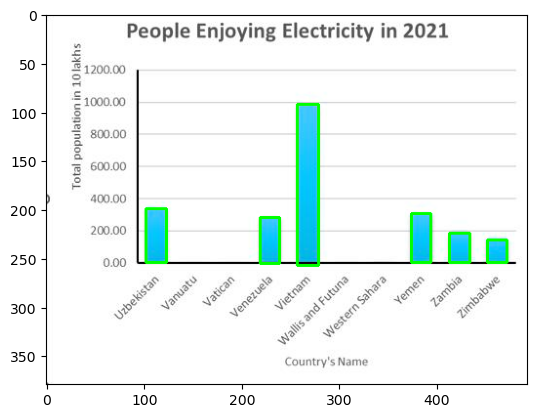

In [160]:
path = test_df['path'].values[18]
img = cv2.imread(path)
results = model([path])
bbox_pred = []
res = results[0].boxes.data
for bbox in res:
    x1, y1, x2, y2, probs, pred = bbox
    bbox_pred.append((int(x1.item()), int(y1.item()), int(x2.item()), int(y2.item())))

data = test_df['data'].values[18]
data = data.replace("'","\"")
data_list = json.loads(data)
bbox_actual = []
for row in data_list:
    x1 = row['x0']
    y1 = row['y0']
    x2 = x1 + row['width']
    y2 = y1 + row['height']
    bbox_actual.append((x1,y1,x2,y2))

bbox_pred = sorted(bbox_pred)

actual_df = pd.DataFrame(bbox_actual, columns=['x1','y1','x2','y2'])
pred_df = pd.DataFrame(bbox_pred, columns=['x1_pred','y1_pred','x2_pred','y2_pred'])

copy = img.copy()
for bbox in bbox_pred:
    x1, y1, x2, y2 = bbox
    cv2.rectangle(copy, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.imshow(copy)
plt.show()

In [162]:
pred_df

,x1_pred,y1_pred,x2_pred,y2_pred
0,102,199,123,254
1,219,208,239,255
2,257,92,279,257
3,374,204,394,254
4,413,224,434,254
5,452,231,472,254


In [161]:
actual_df

,x1,y1,x2,y2
0,102,200,121,256
1,141,254,160,256
2,180,254,199,256
3,219,209,238,256
4,258,93,277,256
5,296,254,316,256
6,335,254,354,256
7,374,205,393,256
8,413,224,432,256
9,452,231,471,256


In [164]:
diffs.to_csv('../data/processed/barplot_diffs.csv')